### Creating Simple Spatial Features in R

Yes, it can be done in R.  It might be preferable to do it in PostGIS, or with GDAL, but it can be done.

In [1]:
#Given a set of rectangles with these (x,y) coords:
a <- "[(2,9) (2,15) (11,15) (11,9)]"
b <- "[(11,9) (11,15) (20,15) (20,9)]"
c <- "[(11,2) (11,9) (20,9) (20,2)]"
d <- "[(2,2) (2,9) (11,9) (11,2)]"
e <- "[(8,6) (8,25) (25,25) (25,6)]"


## Create some polygons and combine them

It's useful to see how R separates coordinate information from attributes, but I'm POSITIVE that there is a better way to do this.  At the moment I don't care as this gives me the examples I need.

In [2]:
# Create individual polygons from their extents using raster::extent, like ST_MakeEnvelope in PostGIS

library(raster)

epsg_4326 <- CRS("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

# polygon A
poly_a <- as(raster::extent(2.0, 11.0, 9.0, 15.0), "SpatialPolygons")
df_a <- data.frame(name="A", id=1, county=1, type="tract")
spdf_a <- SpatialPolygonsDataFrame(poly_a,df_a)

# polygon B
poly_b <- as(raster::extent(11.0, 20.0, 9.0, 15.0), "SpatialPolygons")
df_b <- data.frame(name="B", id=2, county=1, type="tract")
spdf_b <- SpatialPolygonsDataFrame(poly_b,df_b)

# polygon C
poly_c <- as(raster::extent(11.0, 20.0, 2.0, 9.0), "SpatialPolygons")
df_c <- data.frame(name="C", id=3, county=1, type="tract")
spdf_c <- SpatialPolygonsDataFrame(poly_c,df_c)

# polygon D
poly_d <- as(raster::extent(2.0, 11.0, 2.0, 9.0), "SpatialPolygons")
df_d <- data.frame(name="D", id=4, county=1, type="tract")
spdf_d <- SpatialPolygonsDataFrame(poly_d,df_d)

# polygon E
poly_e <- as(raster::extent(8.0, 25.0, 6.0, 25.0), "SpatialPolygons")
df_e <- data.frame(name="E", id=1, county=2, type="forest")
spdf_e <- SpatialPolygonsDataFrame(poly_e,df_e)

# "Bind" Polys A,B,C & D into one
spdf_abcd <- raster::bind(spdf_a, spdf_b, spdf_c, spdf_d, keepnames=TRUE)
proj4string(spdf_abcd) <- epsg_4326

typeof(spdf_abcd)
slotNames(spdf_abcd)
summary(spdf_abcd)
dplyr::glimpse(spdf_abcd@data)

Loading required package: sp



[1] "S4"

[1] "data"        "polygons"    "plotOrder"   "bbox"        "proj4string"

Object of class SpatialPolygonsDataFrame
Coordinates:
  min max
x   2  20
y   2  15
Is projected: FALSE 
proj4string :
[+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs +towgs84=0,0,0]
Data attributes:
 name        id           county     type  
 A:1   Min.   :1.00   Min.   :1   tract:4  
 B:1   1st Qu.:1.75   1st Qu.:1            
 C:1   Median :2.50   Median :1            
 D:1   Mean   :2.50   Mean   :1            
       3rd Qu.:3.25   3rd Qu.:1            
       Max.   :4.00   Max.   :1            

Observations: 4
Variables: 4
$ name   <fct> A, B, C, D
$ id     <dbl> 1, 2, 3, 4
$ county <dbl> 1, 1, 1, 1
$ type   <fct> tract, tract, tract, tract


### Create some points

Points are a little easier to create than polygons.  There is a bit of a trick though in creating the "coords".  Below is the way that I've been using.  There are many other ways to do it.

In [3]:
# Create some point data, maybe it represents temperature readings, or something...
temp_df <- read.table(header = TRUE, text="
id  x  y  temp
 1  5  21 50
 2  18 20 49.5
 3  9  13 52
 4  17 13 51
 5  7  12  53
 6  23 12 50
 7  12 11 52
 8  6  7  57
 9  10 7  57
 10 15 7  55
 11 16 3  54
 12 22 3  54")

# Convert the point df into a SpatialPointsDataFrame
xy <- temp_df[c("x", "y")]
temp_spdf <- SpatialPointsDataFrame(coords = xy, 
                                    data = temp_df,
                                    proj4string = epsg_4326)

summary(temp_spdf)

Object of class SpatialPointsDataFrame
Coordinates:
  min max
x   5  23
y   3  21
Is projected: FALSE 
proj4string :
[+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs +towgs84=0,0,0]
Number of points: 12
Data attributes:
       id              x               y              temp      
 Min.   : 1.00   Min.   : 5.00   Min.   : 3.00   Min.   :49.50  
 1st Qu.: 3.75   1st Qu.: 8.50   1st Qu.: 7.00   1st Qu.:50.75  
 Median : 6.50   Median :13.50   Median :11.50   Median :52.50  
 Mean   : 6.50   Mean   :13.33   Mean   :10.75   Mean   :52.88  
 3rd Qu.: 9.25   3rd Qu.:17.25   3rd Qu.:13.00   3rd Qu.:54.25  
 Max.   :12.00   Max.   :23.00   Max.   :21.00   Max.   :57.00  

### Basic Plotting

Plot everything on the same canvas and add some labels.

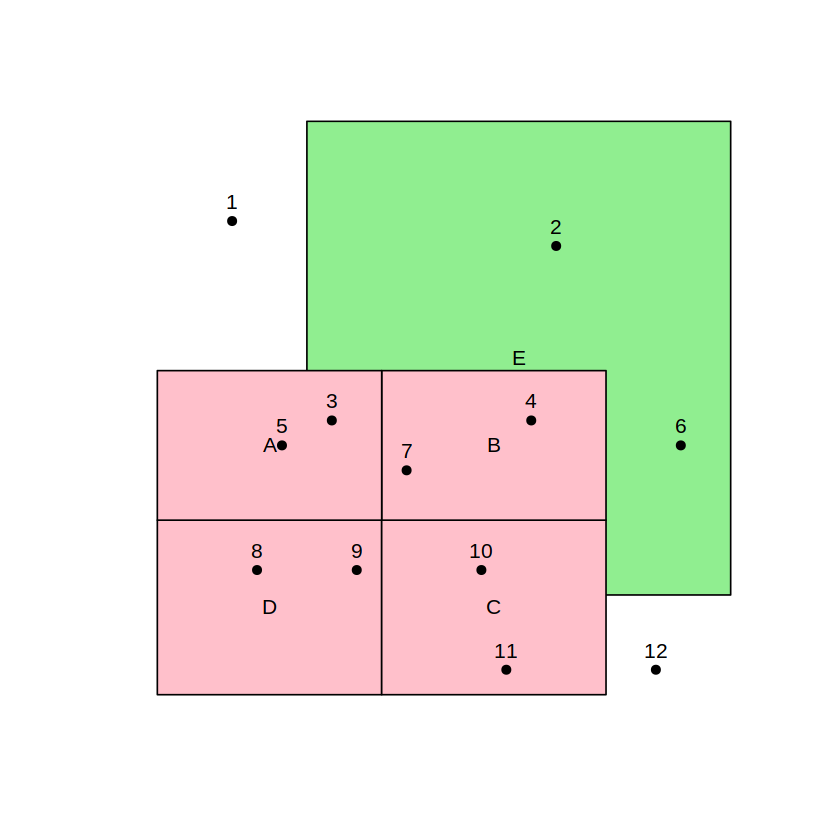

In [4]:
# bbox (just needed to be able to plot 2 objects that don't share the same bbox, could use xlim?)
bbox <- as(raster::extent(2.0, 25.0, 2.0, 25.0), "SpatialPolygons")

# Invisible bbox to set the plot extent
plot(bbox, col = "transparent", border = "transparent")

# SPDF features
plot(spdf_e, col = "lightgreen", add = TRUE)
plot(spdf_abcd, col = "pink", add = TRUE)

# Label the polygons with their names
abcd <- suppressWarnings(rgeos::polygonsLabel(spdf_abcd, spdf_abcd$name, method = "centroid", doPlot = TRUE))
e <- suppressWarnings(rgeos::polygonsLabel(spdf_e, spdf_e$name, method = "buffer", doPlot = TRUE))

# Plot the points and label them
# See http://www.sthda.com/english/wiki/r-plot-pch-symbols-the-different-point-shapes-available-in-r
plot(temp_spdf, add = TRUE, col = "black", pch = 16)
# Label the points
text(temp_spdf, labels = temp_spdf$id, pos = 3) 

In [11]:
# Save off the data so we can use it later
assign("sample_tracts", spdf_abcd)
save(list = c("sample_tracts"), file = 'sample_tracts.RData')

assign("sample_forest", spdf_e)
save(list = c("sample_forest"), file = 'sample_forest.RData')

assign("sample_temps", temp_spdf)
save(list = c("sample_temps"), file = 'sample_temps.RData')

In [12]:
list.files()

[1] "sample_forest.RData"                "sample_temps.RData"                
[3] "sample_tracts.RData"                "Simple_Spatial_Features_in_R.ipynb"
[5] "spatial_fun.R"